# Let's figure out these freaking learning rates

In [1]:
%load_ext autoreload
%autoreload 2

In [62]:
import re, os
import numpy as np
import xarray as xr
import tensorflow.keras as keras
import datetime
import pdb
import matplotlib.pyplot as plt
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
from src.train import *
from src.clr import LRFinder, OneCycleLR
import matplotlib.ticker as ticker

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

In [61]:
class RunLRFind():
    def __init__(self, exp_id, train_years=['2014', '2015'],
                 ext_exp_id='81-resnet_d3_dr_0.1'):
        self.train_years = train_years
        self.args = load_args(f'../nn_configs/B/{exp_id}.yml')
        self.ext_exp_id = ext_exp_id
        self.load_data()
        self.build_model()
        
        
    def build_model(self):
        args = self.args
        dg_train = self.dg_train
        if args['network_type'] == 'resnet':
            model = build_resnet(
                **args, input_shape=dg_train.shape,
            )
        elif args['network_type'] == 'uresnet':
            model = build_uresnet(
                **args, input_shape=dg_train.shape,
            )
        if args['loss'] == 'lat_mse':
            loss = create_lat_mse(dg_train.data.lat)
        if args['loss'] == 'lat_rmse':
            loss = create_lat_rmse(dg_train.data.lat)
        if args['optimizer'] == 'adam':
            opt = keras.optimizers.Adam(args['lr'])
        elif args['optimizer'] =='adadelta':
            opt = keras.optimizers.Adadelta(args['lr'])
        elif args['optimizer'] =='sgd':
            opt = keras.optimizers.SGD(args['lr'], momentum=args['momentum'], nesterov=True)
        elif optimizer == 'rmsprop':
            opt = keras.optimizers.RMSprop(lr, momentum=momentum)
        model.compile(opt, loss, metrics=['mse'])
        self.model = model
        
    def load_data(self):
        if self.ext_exp_id is None:
            self.args['train_years'] = self.train_years
            dg_train, dg_valid, dg_test = load_data(**self.args)
            self.dg_train, self.dg_valid = dg_train, dg_test
        else:
            mean = xr.open_dataarray(f"{self.args['model_save_dir']}/{self.ext_exp_id}_mean.nc")
            std = xr.open_dataarray(f"{self.args['model_save_dir']}/{self.ext_exp_id}_std.nc")
            self.args['ext_mean'] = mean
            self.args['ext_std'] = std
            dg_test = load_data(**self.args, only_test=True)
            self.dg_train = dg_test
        
    def find_lr(self, minimum_lr=1e-6, maximum_lr=1e-3, lr_scale='exp'):
        self.lrf = LRFinder(
            self.dg_train.n_samples, self.dg_train.batch_size,
            minimum_lr=minimum_lr, maximum_lr=maximum_lr,
            lr_scale=lr_scale, save_dir='./', verbose=0, 
            validation_data=self.dg_valid if self.ext_exp_id is None else None,
            stopping_criterion_factor=100
        )
        self.model.fit(self.dg_train, epochs=1, callbacks=[self.lrf])
        return self.lrf
        
    def plot(self, xlim=None, ylim=None, log=False):
        fig, ax = plt.subplots(figsize=(8, 8))
        plt.plot(10**self.lrf.lrs, self.lrf.losses)
        plt.xlabel('lr'); plt.ylabel('loss')
        if log: plt.yscale('log')
        if ylim is not None: plt.ylim(ylim)
        if xlim is not None: plt.xlim(xlim)
        x_labels = ax.get_xticks()
        ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
        
def plot_lrfs(lrfs, xlim=None, ylim=None, log=False, labels=None, smooth = False):
    fig, ax = plt.subplots(figsize=(15, 8))
    for i, lrf in enumerate(lrfs): 
        lrs = lrf.lrs
        if lrf.lr_scale == 'exp': lrs = 10** lrs
        losses = lrf.losses
        if smooth: losses = np.convolve(losses, np.ones(5)/5, 'same')
        ax.plot(lrs, losses, label=labels[i] if not labels is None else None)
    plt.xlabel('lr'); plt.ylabel('loss')
    if log: plt.yscale('log')
    if ylim is not None: plt.ylim(ylim)
    if xlim is not None: plt.xlim(xlim)
    x_labels = ax.get_xticks()
    ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.0e'))
    if labels is not None: plt.legend()

In [127]:
lrf = RunLRFind('81-resnet_d3_dr_0.1')

In [129]:
lrfs[0].use_validation_set

False

In [22]:
lrfs = []
lrf.build_model()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 55s 201ms/step - loss: 45.5579 - mse: 55.1366


In [23]:
lrf.dg_train.lead_time = 6
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 274 steps
274/274 [==============================] - 57s 207ms/step - loss: 12.0104 - mse: 15.7968


In [24]:
lrf.dg_train.lead_time = 120
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 272 steps
272/272 [==============================] - 55s 202ms/step - loss: 20.6105 - mse: 25.7263


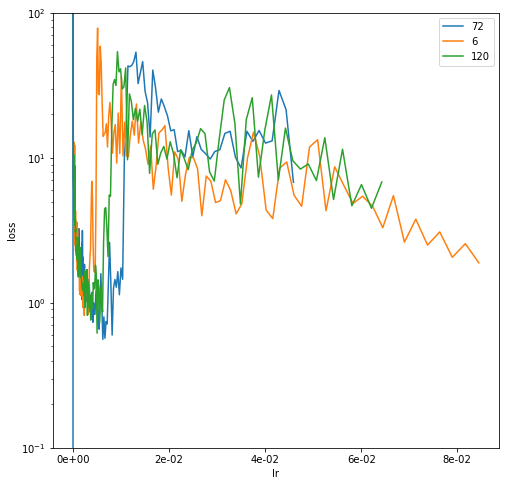

In [25]:
plot_lrfs(lrfs, log=True, ylim=(1e-1, 100), labels = ['72', '6', '120'])
plt.axvline(5e-5)

In [26]:
lrf.dg_train.lead_time = 6
lrf.args['loss'] = 'lat_rmse'
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 274 steps
274/274 [==============================] - 56s 206ms/step - loss: 4.1241 - mse: 49.8600


In [27]:
lrf.dg_train.lead_time = 72
lrf.args['loss'] = 'lat_rmse'
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 54s 199ms/step - loss: 4.6607 - mse: 108.0164


In [28]:
lrf.dg_train.lead_time = 120
lrf.args['loss'] = 'lat_rmse'
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 272 steps
272/272 [==============================] - 56s 207ms/step - loss: 4.9196 - mse: 108.7999


(1e-05, 0.1)

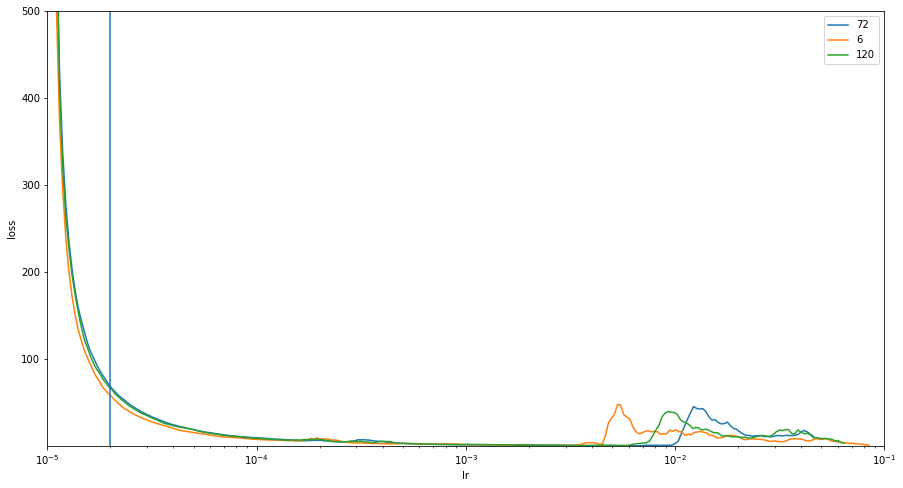

In [67]:
plot_lrfs(lrfs[:3], log=False, ylim=(5e-1, 500), labels = ['72', '6', '120', '6_rmse', '72_rmse', '120_rmse'], xlim=(0, 5e-2), smooth=True)
plt.axvline(2e-5)
plt.xscale('log'); plt.xlim(1e-5, 1e-1)

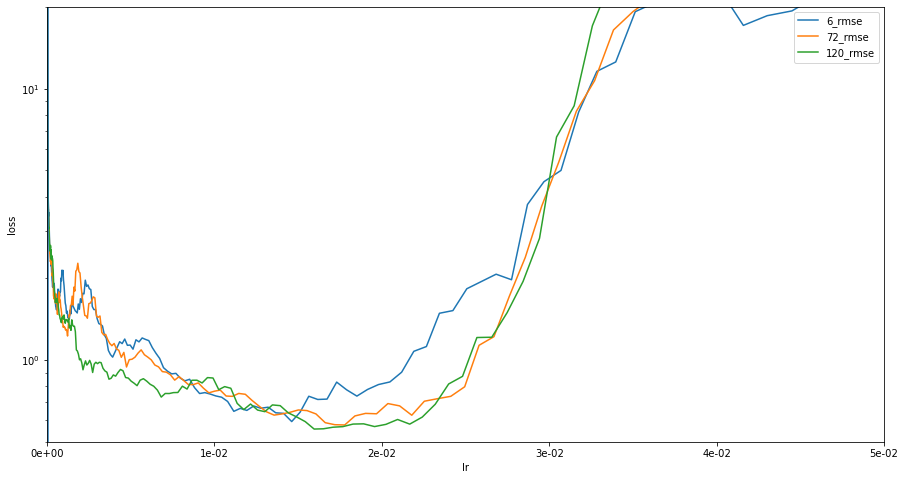

In [42]:
plot_lrfs(lrfs[3:], log=True, ylim=(5e-1, 20), labels = ['72', '6', '120', '6_rmse', '72_rmse', '120_rmse'][3:], xlim=(0, 5e-2), smooth=True)
plt.axvline(5e-5)

In [53]:
lrf.dg_train.lead_time = 72
lrf.args['loss'] = 'lat_mse'
lrf.args['optimizer'] = 'sgd'
lrf.args['momentum'] = 0.9
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 62s 226ms/step - loss: 266743645.3892 - mse: 275047904.0000


In [60]:
lrf.dg_train.lead_time = 72
lrf.args['loss'] = 'lat_mse'
lrf.args['optimizer'] = 'rmsprop'
lrf.args['momentum'] = 0.9
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='exp', minimum_lr=1e-5, maximum_lr=1e-1))

UnboundLocalError: local variable 'opt' referenced before assignment

In [105]:
lrf.dg_train.lead_time = 72
lrf.args['optimizer'] = 'adam'
lrf.build_model(); lrf.dg_train.on_epoch_end()
lrfs.append(lrf.find_lr(lr_scale='linear', minimum_lr=1e-5, maximum_lr=5e-3))

  ...
    to  
  ['...']
Train for 273 steps
273/273 [==============================] - 55s 202ms/step - loss: 3.1622 - mse: 4.2675


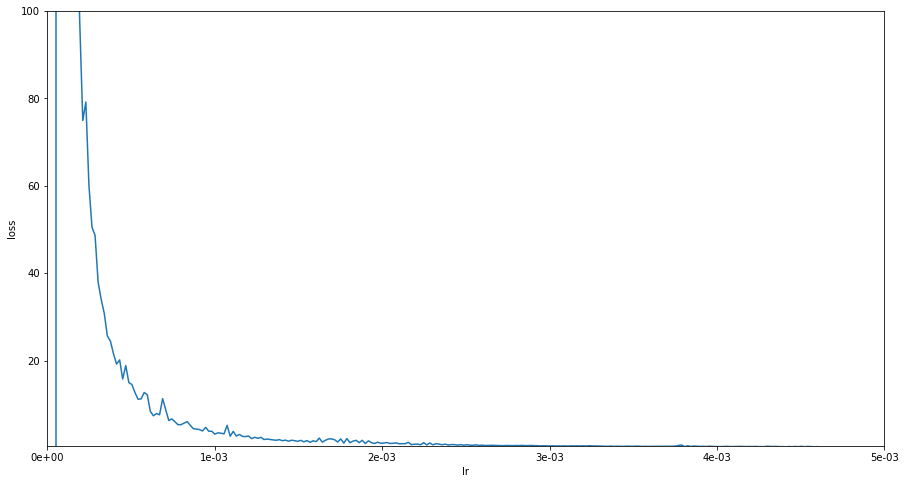

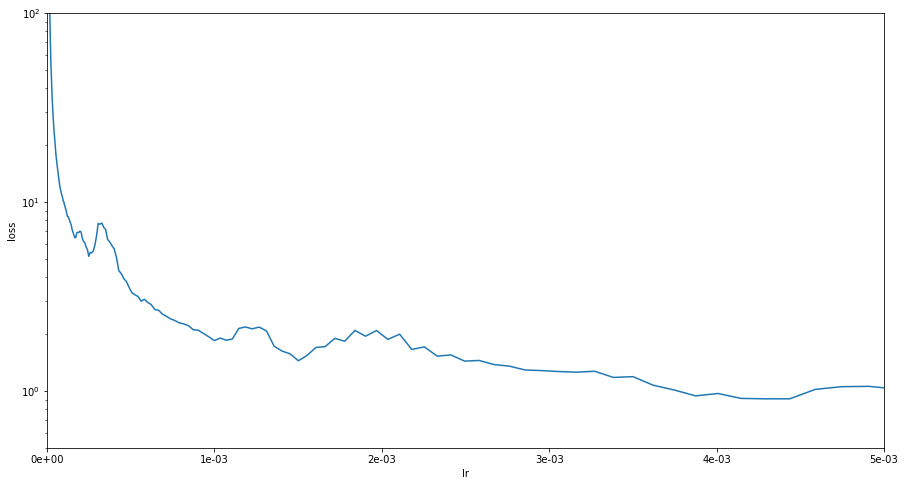

In [107]:
plot_lrfs(lrfs[-1:], log=False, ylim=(5e-1, 100), xlim=(0, 5e-3), smooth=False)
plt.axvline(5e-5)
plot_lrfs(lrfs[:1], log=True, ylim=(5e-1, 100), xlim=(0, 5e-3), smooth=True)


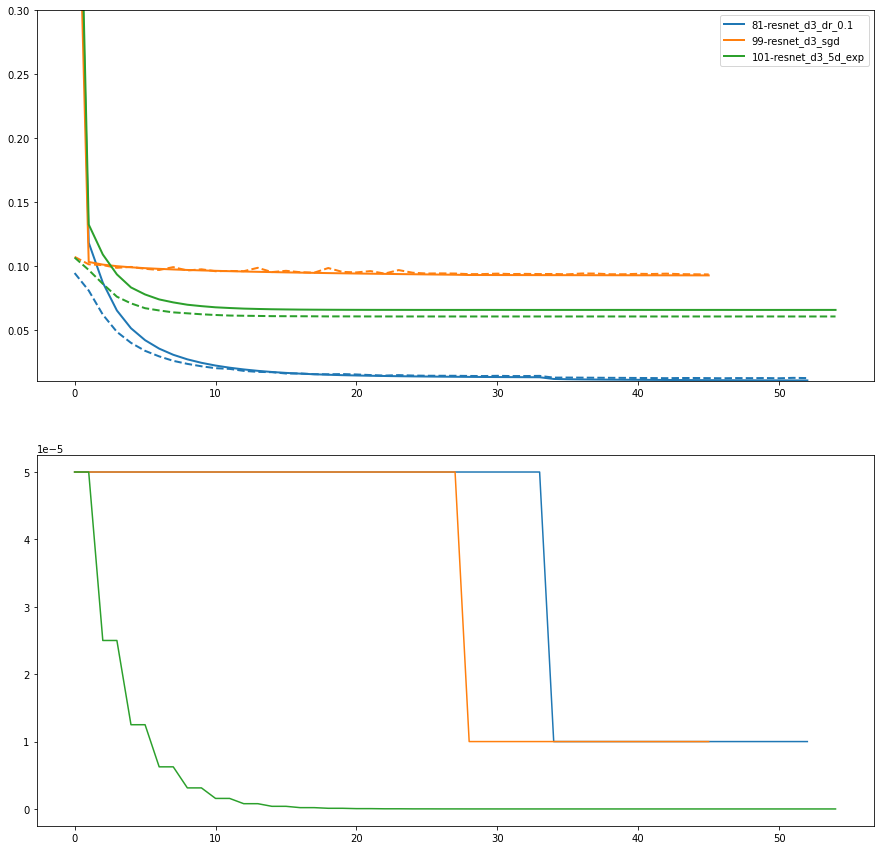

In [52]:
plot_losses('/home/rasp/data/myWeatherBench/predictions/saved_models/', 
            [81, 99, 101], log=False, ylim=(0.01, 0.3)
        )

In [68]:
max_lr=2e-5

In [72]:
??OneCycleLR

Init signature:
OneCycleLR(
    max_lr,
    end_percentage=0.1,
    scale_percentage=None,
    maximum_momentum=0.95,
    minimum_momentum=0.85,
    verbose=True,
)
Docstring:     
Abstract base class used to build new callbacks.

Attributes:
    params: dict. Training parameters
        (eg. verbosity, batch size, number of epochs...).
    model: instance of `keras.models.Model`.
        Reference of the model being trained.
    validation_data: Deprecated. Do not use.

The `logs` dictionary that callback methods
take as argument will contain keys for quantities relevant to
the current batch or epoch.

Currently, the `.fit()` method of the `Model` class
will include the following quantities in the `logs` that
it passes to its callbacks:

    on_epoch_end: logs include `acc` and `loss`, and
        optionally include `val_loss`
        (if validation is enabled in `fit`), and `val_acc`
        (if validation and accuracy monitoring are enabled).
    on_batch_begin: logs include `size`,

In [112]:
one_cycle = OneCycleLR(max_lr,
    end_percentage=0.1, verbose=0)

In [116]:
NUM_SAMPLES = 2000
NUM_EPOCHS = 100
BATCH_SIZE = 500
MAX_LR = 0.1

# Data
X = np.random.rand(NUM_SAMPLES, 10)
Y = np.random.randint(0, 2, size=NUM_SAMPLES)

# Model
inp = Input(shape=(10,))
x = Dense(5, activation='relu')(inp)
x = Dense(1, activation='sigmoid')(x)
model = keras.models.Model(inp, x)

In [125]:
optimizer = keras.optimizers.SGD()

In [126]:
optimizer.

{'name': 'SGD',
 'learning_rate': 0.01,
 'decay': 0.0,
 'momentum': 0.0,
 'nesterov': False}

In [123]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [124]:
model.optimizer

In [117]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(X, Y, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, callbacks=[one_cycle], verbose=0)

ValueError: Momentum can be updated only on SGD optimizer !

In [118]:
plt.plot(one_cycle.history['lr'])

KeyError: 'lr'

In [1]:
plot_losses('/home/rasp/data/myWeatherBench/predictions/saved_models/', 
            ['81.1', 103], log=False, ylim=(0.005, 0.02)
        )

NameError: name 'plot_losses' is not defined